In [1]:
import os
import h5py
import time
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as ticker
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

#import package for Gaussian Process Regression (GPR)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
# import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Input, Dense, Activation,Dropout
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional
from keras import backend as K
### Set-up - Define file location
filename = 'N-CMAPSS_DS01-005.h5'

# Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 

# Create DataFrames with the specified columns
df_A_dev = DataFrame(data=A_dev, columns=A_var)
df_W_dev = DataFrame(data=W_dev, columns=W_var)
df_T_dev = DataFrame(data=T_dev, columns=T_var)
df_X_s_dev = DataFrame(data=X_s_dev, columns=X_s_var)
df_X_v_dev = DataFrame(data=X_v_dev, columns=X_v_var)

# Separate features (X) and target variable (y)
df_A_test = DataFrame(data=A_test, columns=A_var)
df_W_test = DataFrame(data=W_test, columns=W_var)
df_T_test = DataFrame(data=T_test, columns=T_var)
df_X_s_test = DataFrame(data=X_s_test, columns=X_s_var)
df_X_v_test = DataFrame(data=X_v_test, columns=X_v_var)




In [2]:
# Add columns to the dataframes: unit, cycle and Fc
df_T_dev['unit'] = df_A_dev['unit'].values
df_T_dev['cycle'] = df_A_dev['cycle'].values
df_T_dev['Fc'] = df_A_dev['Fc'].values
df_T_dev['hs'] = df_A_dev['hs'].values

df_W_dev['unit'] = df_A_dev['unit'].values
df_W_dev['cycle'] = df_A_dev['cycle'].values
df_W_dev['Fc'] = df_A_dev['Fc'].values
df_W_dev['hs'] = df_A_dev['hs'].values


df_T_test['unit'] = df_A_test['unit'].values
df_T_test['cycle'] = df_A_test['cycle'].values
df_T_test['Fc'] = df_A_test['Fc'].values
df_T_test['hs'] = df_A_test['hs'].values

df_W_test['unit'] = df_A_test['unit'].values
df_W_test['cycle'] = df_A_test['cycle'].values
df_W_test['Fc'] = df_A_test['Fc'].values
df_W_test['hs'] = df_A_test['hs'].values

df_X_s_dev['unit'] = df_A_dev['unit'].values
df_X_s_dev['cycle'] = df_A_dev['cycle'].values
df_X_s_dev['Fc'] = df_A_dev['Fc'].values
df_X_s_dev['hs'] = df_A_dev['hs'].values

df_X_v_dev['unit'] = df_A_dev['unit'].values
df_X_v_dev['cycle'] = df_A_dev['cycle'].values
df_X_v_dev['Fc'] = df_A_dev['Fc'].values
df_X_v_dev['hs'] = df_A_dev['hs'].values

df_X_s_test['unit'] = df_A_test['unit'].values
df_X_s_test['cycle'] = df_A_test['cycle'].values
df_X_s_test['Fc'] = df_A_test['Fc'].values
df_X_s_test['hs'] = df_A_test['hs'].values

df_X_v_test['unit'] = df_A_test['unit'].values
df_X_v_test['cycle'] = df_A_test['cycle'].values
df_X_v_test['Fc'] = df_A_test['Fc'].values
df_X_v_test['hs'] = df_A_test['hs'].values

T_map_train = df_T_dev[['unit','cycle', 'Fc','hs','fan_eff_mod', 'fan_flow_mod', 'LPC_eff_mod', 'LPC_flow_mod', 'HPC_eff_mod', 'HPC_flow_mod', 'HPT_eff_mod', 'HPT_flow_mod', 'LPT_eff_mod', 'LPT_flow_mod']]
A_map_train = df_A_dev[['unit', 'cycle', 'Fc','hs']]
W_map_train = df_W_dev[['unit', 'cycle', 'Fc','hs','alt', 'Mach', 'TRA','T2']]
X_s_map_train = df_X_s_dev[['unit', 'cycle', 'Fc','hs','T48', 'T50', 'P50', 'Wf', 'Nf', 'Nc', 'T24', 'T30', 'P15', 'P21', 'P24', 'Ps30', 'P40', 'P2']]
X_v_map_train = df_X_v_dev[['unit', 'cycle', 'Fc','hs','T40', 'P30', 'P45', 'W21', 'W22', 'W25', 'W31', 'W32', 'W48', 'W50', 'SmFan', 'SmLPC', 'SmHPC', 'phi']]

T_map_test = df_T_test[['unit','cycle', 'Fc', 'hs','fan_eff_mod', 'fan_flow_mod', 'LPC_eff_mod', 'LPC_flow_mod', 'HPC_eff_mod', 'HPC_flow_mod', 'HPT_eff_mod', 'HPT_flow_mod', 'LPT_eff_mod', 'LPT_flow_mod']]
A_map_test = df_A_test[['unit', 'cycle', 'Fc', 'hs']]
W_map_test = df_W_test[['unit', 'cycle', 'Fc', 'hs','alt', 'Mach', 'TRA','T2']]
X_s_map_test = df_X_s_test[['unit', 'cycle', 'Fc', 'hs','T48', 'T50', 'P50', 'Wf', 'Nf', 'Nc', 'T24', 'T30', 'P15', 'P21', 'P24', 'Ps30', 'P40', 'P2']]
X_v_map_test = df_X_v_test[['unit', 'cycle', 'Fc', 'hs','T40', 'P30', 'P45', 'W21', 'W22', 'W25', 'W31', 'W32', 'W48', 'W50', 'SmFan', 'SmLPC', 'SmHPC', 'phi']]

In [3]:
df_X_v_dev.describe()
	

,T40,P30,P45,W21,W22,W25,W31,W32,W48,W50,SmFan,SmLPC,SmHPC,phi,unit,cycle,Fc,hs
count,4.906636e+06,4.906636e+06,4.906636e+06,4.906636e+06,4.906636e+06,4.906636e+06,4.906636e+06,4.906636e+06,4.906636e+06,4.906636e+06,4.906636e+06,4.906636e+06,4.906636e+06,4.906636e+06,4.906636e+06,4.906636e+06,4.906636e+06,4.906636e+06
mean,2.539059e+03,2.521156e+02,4.459953e+01,1.958580e+03,1.722231e+02,1.722231e+02,1.985261e+01,1.191156e+01,1.613613e+02,1.708337e+02,1.853523e+01,8.130454e+00,2.839386e+01,3.820732e+01,3.727439e+00,4.550336e+01,2.301987e+00,2.601379e-01
std,1.791202e+02,6.216282e+01,1.116563e+01,3.619473e+02,3.638526e+01,3.638496e+01,4.297974e+00,2.578784e+00,3.513150e+01,3.713260e+01,1.996429e+00,1.004225e+00,2.445196e+00,2.853163e+00,1.643444e+00,2.663813e+01,7.458150e-01,4.387097e-01
min,1.467689e+03,8.597042e+01,1.492471e+01,9.777522e+02,7.001475e+01,7.005396e+01,7.783874e+00,4.670324e+00,6.291609e+01,6.676919e+01,9.877193e+00,2.281794e+00,2.121792e+01,1.474362e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,2.417815e+03,2.057616e+02,3.629979e+01,1.685994e+03,1.455287e+02,1.455295e+02,1.669942e+01,1.001965e+01,1.355732e+02,1.435771e+02,1.756724e+01,7.445914e+00,2.631493e+01,3.625171e+01,2.000000e+00,2.300000e+01,2.000000e+00,0.000000e+00
50%,2.552982e+03,2.391646e+02,4.211538e+01,1.957922e+03,1.672417e+02,1.672428e+02,1.926431e+01,1.155859e+01,1.564192e+02,1.656170e+02,1.849621e+01,8.185888e+00,2.806754e+01,3.860138e+01,4.000000e+00,4.500000e+01,2.000000e+00,0.000000e+00
75%,2.652880e+03,2.872531e+02,5.083866e+01,2.202693e+03,1.941497e+02,1.941500e+02,2.244272e+01,1.346563e+01,1.824501e+02,1.931280e+02,1.971424e+01,8.872949e+00,3.014961e+01,4.035535e+01,5.000000e+00,6.700000e+01,3.000000e+00,1.000000e+00
max,3.024852e+03,4.768547e+02,8.525095e+01,3.057762e+03,2.972408e+02,2.972384e+02,3.462003e+01,2.077202e+01,2.824817e+02,2.988297e+02,2.727136e+01,1.315456e+01,5.423255e+01,4.620289e+01,6.000000e+00,1.000000e+02,3.000000e+00,1.000000e+00


In [4]:
# Calculate the 3rd quartile values for each unique combination of unit, cycle, and Fc values in the training set
df_T_map_1q_train = T_map_train.groupby(['unit', 'cycle', 'Fc','hs']).quantile(0.75).reset_index()
df_W_map_1q_train = W_map_train.groupby(['unit', 'cycle', 'Fc','hs']).quantile(0.75).reset_index()
# Calculate the 3rd qartile values for each unique combination of unit, cycle, and Fc values in the test set
df_T_map_1q_test = T_map_test.groupby(['unit', 'cycle', 'Fc','hs']).quantile(0.75).reset_index()
df_W_map_1q_test = W_map_test.groupby(['unit', 'cycle', 'Fc','hs']).quantile(0.75).reset_index()


In [5]:
df_T_map_1q_train.describe()

,unit,cycle,Fc,hs,fan_eff_mod,fan_flow_mod,LPC_eff_mod,LPC_flow_mod,HPC_eff_mod,HPC_flow_mod,HPT_eff_mod,HPT_flow_mod,LPT_eff_mod,LPT_flow_mod
count,553.000000,553.000000,553.000000,553.000000,553.0,553.0,553.0,553.0,553.0,553.0,553.000000,553.0,553.0,553.0
mean,3.506329,46.980108,1.943942,0.285714,0.0,0.0,0.0,0.0,0.0,0.0,-0.003811,0.0,0.0,0.0
std,1.718520,27.259714,0.804496,0.452163,0.0,0.0,0.0,0.0,0.0,0.0,0.004065,0.0,0.0,0.0
min,1.000000,1.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.018668,0.0,0.0,0.0
25%,2.000000,24.000000,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.005057,0.0,0.0,0.0
50%,4.000000,47.000000,2.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.001962,0.0,0.0,0.0
75%,5.000000,70.000000,3.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.001111,0.0,0.0,0.0
max,6.000000,100.000000,3.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,-0.000117,0.0,0.0,0.0


In [6]:
# Make an inference of T_map_mean data and compare it with the original data
# Using the Maximum a posteriori (MAP) estimae of the T_map_mean data
# The MAP estimate is the mode of the posterior distribution

# Define a likelihood function for the Gaussian Process

from scipy.optimize import minimize
def likelihood(theta, X, y, noise):
    # define the residuals for the Gaussian Process
    residuals = y - gp(X, y, theta, noise)
    
    # calculate the negative log likelihood
    neg_log_like = 0.5 * np.sum(residuals**2) / noise**2 + 0.5 * len(X) * np.log(noise**2)
    
    # return the negative log likelihood
    return neg_log_like

# define the Several Gaussian Process for multioutput regression

def gp(X, y, theta, noise):
    # define the kernel for the Gaussian Process
    kernel = C(theta[0], (1e-3, 1e3)) * RBF(theta[1], (1e-3, 1e3))
    # define the Gaussian Process
    gp = GaussianProcessRegressor(kernel=kernel, alpha=noise**2, n_restarts_optimizer=20)
    # fit the Gaussian Process to the data
    gp.fit(X, y)
    # return the Gaussian Process predictions
    return gp.predict(X)

# define the log prior
def prior(theta):
    # set the log prior to zero
    log_prior = 0
    # loop over all the parameters
    for i in range(len(theta)):
        # calculate the log prior
        log_prior += np.log(1 / (1 + theta[i]**2))
    # return the log prior
    return log_prior

# define the log posterior
def log_posterior(theta, X, y, noise):
    # return the log posterior
    return likelihood(theta, X, y, noise) + prior(theta)

def neg_log_posterior(theta, X, y, noise):
    # calculate likelihood and prior
    like = likelihood(theta, X, y, noise)
    prior_val = prior(theta)
    # return the negative log posterior
    return - (like + prior_val)

# define the MAP estimate function
def MAP(X, y, noise):
    # define the initial guess for the parameters
    initial = [1] * (X.shape[1] + 1)
    # minimize the negative log posterior
    soln = minimize(neg_log_posterior, initial, args=(X, y, noise))
    # return the MAP estimate
    return soln.x

#Use the MAP estimate to make an inference of the T_map_mean data
# define the noise
noise = 0.1
X= df_T_map_1q_train[['unit', 'cycle', 'Fc','hs']]
X_1 = df_T_map_1q_test[['unit', 'cycle', 'Fc','hs']]
y= df_T_map_1q_train[['fan_eff_mod', 'fan_flow_mod', 'LPC_eff_mod', 'LPC_flow_mod', 'HPC_eff_mod', 'HPC_flow_mod', 'HPT_eff_mod', 'HPT_flow_mod', 'LPT_eff_mod', 'LPT_flow_mod']]
y_1 = df_T_map_1q_test[['fan_eff_mod', 'fan_flow_mod', 'LPC_eff_mod', 'LPC_flow_mod', 'HPC_eff_mod', 'HPC_flow_mod', 'HPT_eff_mod', 'HPT_flow_mod', 'LPT_eff_mod', 'LPT_flow_mod']]
# remove NaN values from the y input
y = y[~np.isnan(y).any(axis=1)]
#standardize the data
scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)
X_1 = scaler_X.transform(X_1)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y)
y_1 = scaler_y.transform(y_1)
# calculate the MAP estimate
theta = MAP(X, y, noise)
# predict the T_map_mean data using the MAP estimate
y_pred = gp(X, y, theta, noise)
# clip the predicted values to the maximum value of the training data
y_pred = np.clip(y_pred, None, np.max(y))



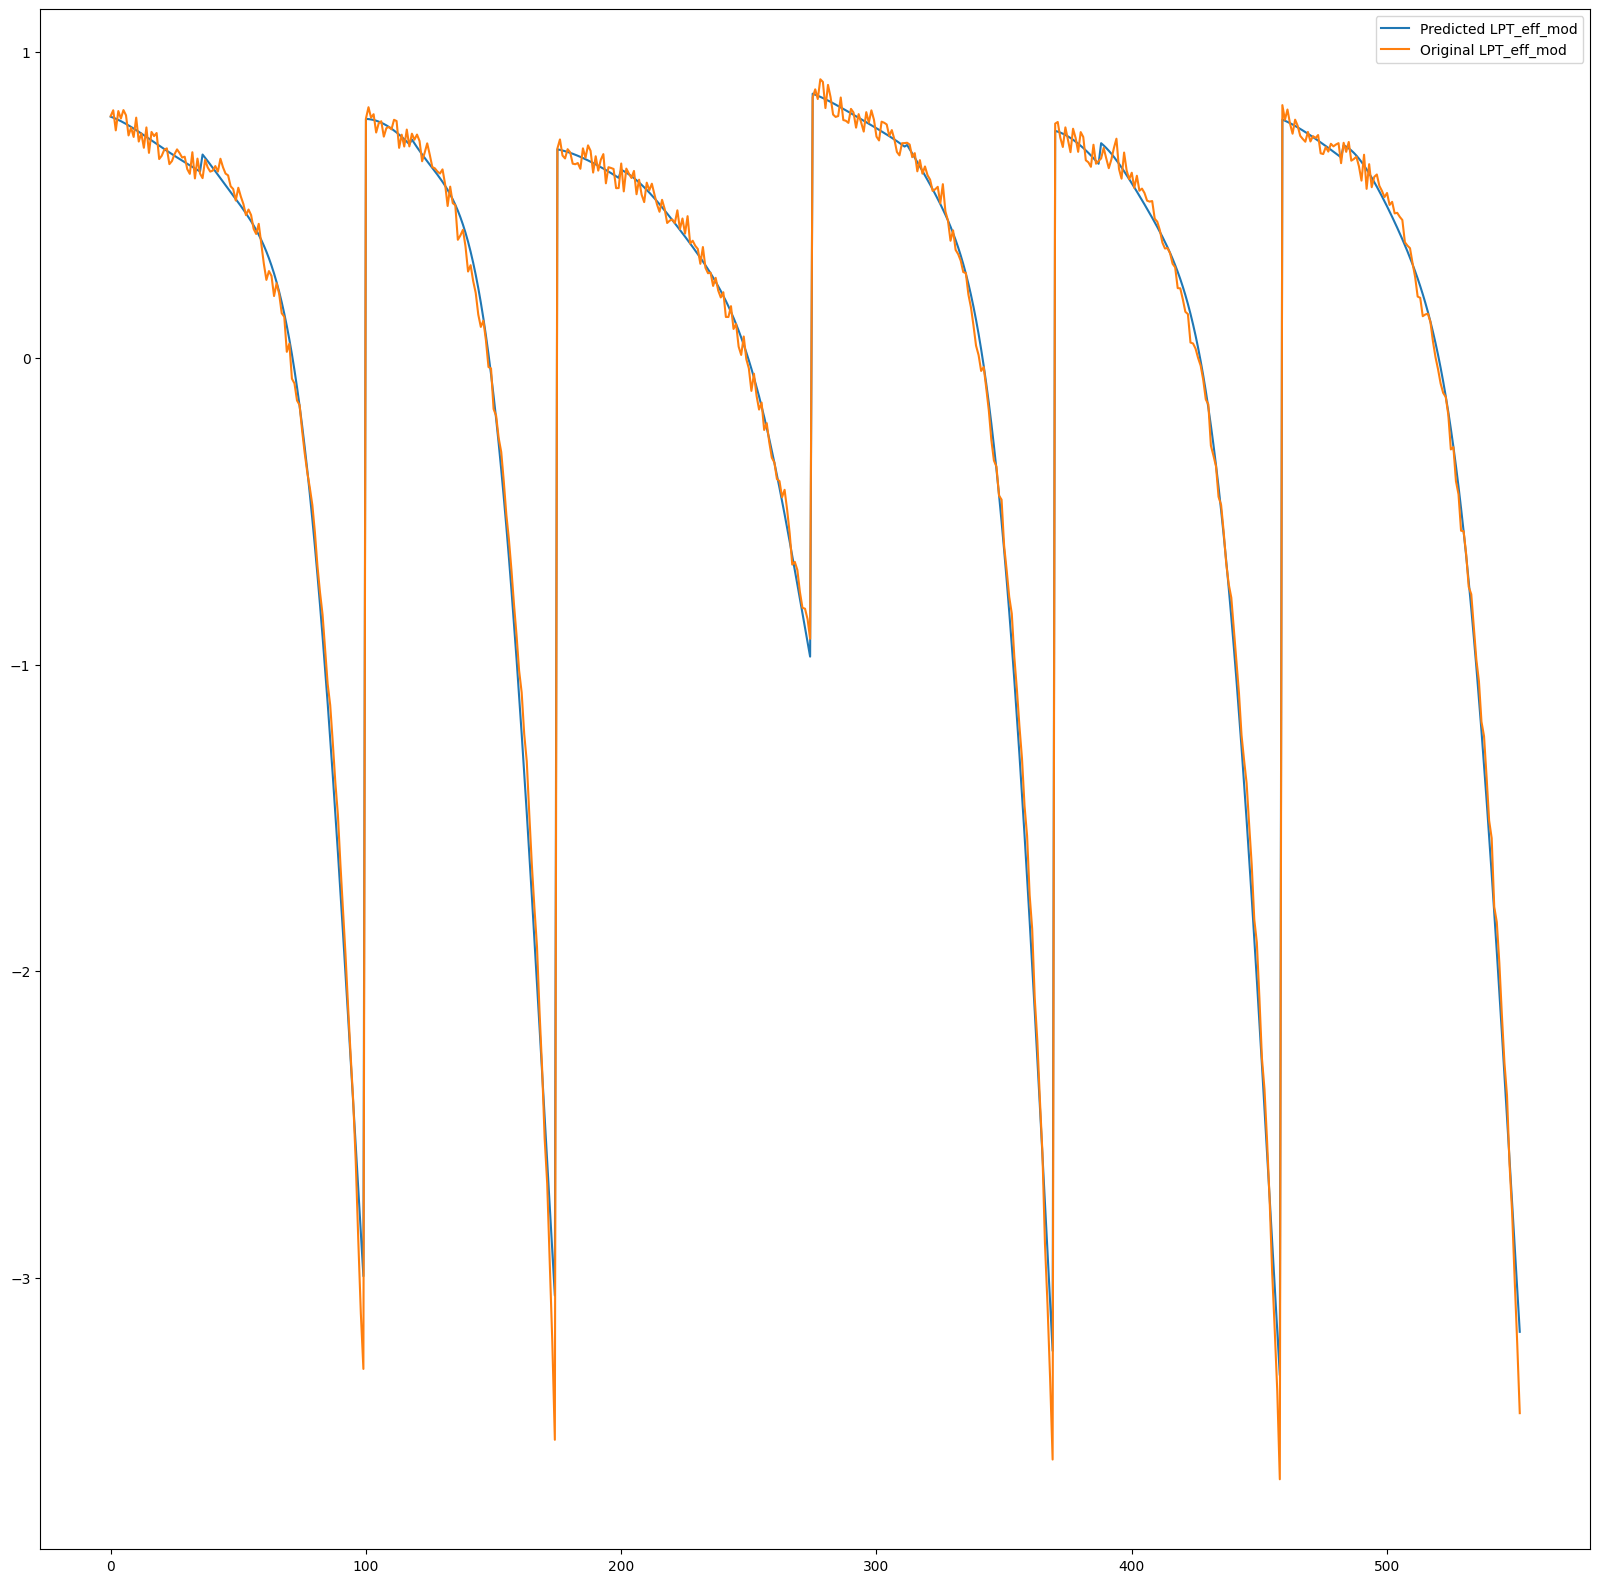

In [7]:
#plot the predicted T_map_mean data and compare it with the original data
# plot the predicted data
plt.figure(figsize=(20, 20))
plt.plot(y_pred[:,6], label='Predicted LPT_eff_mod')    
# plot the original data
plt.plot(y[:,6], label='Original LPT_eff_mod')
plt.legend(loc='best')
plt.show()


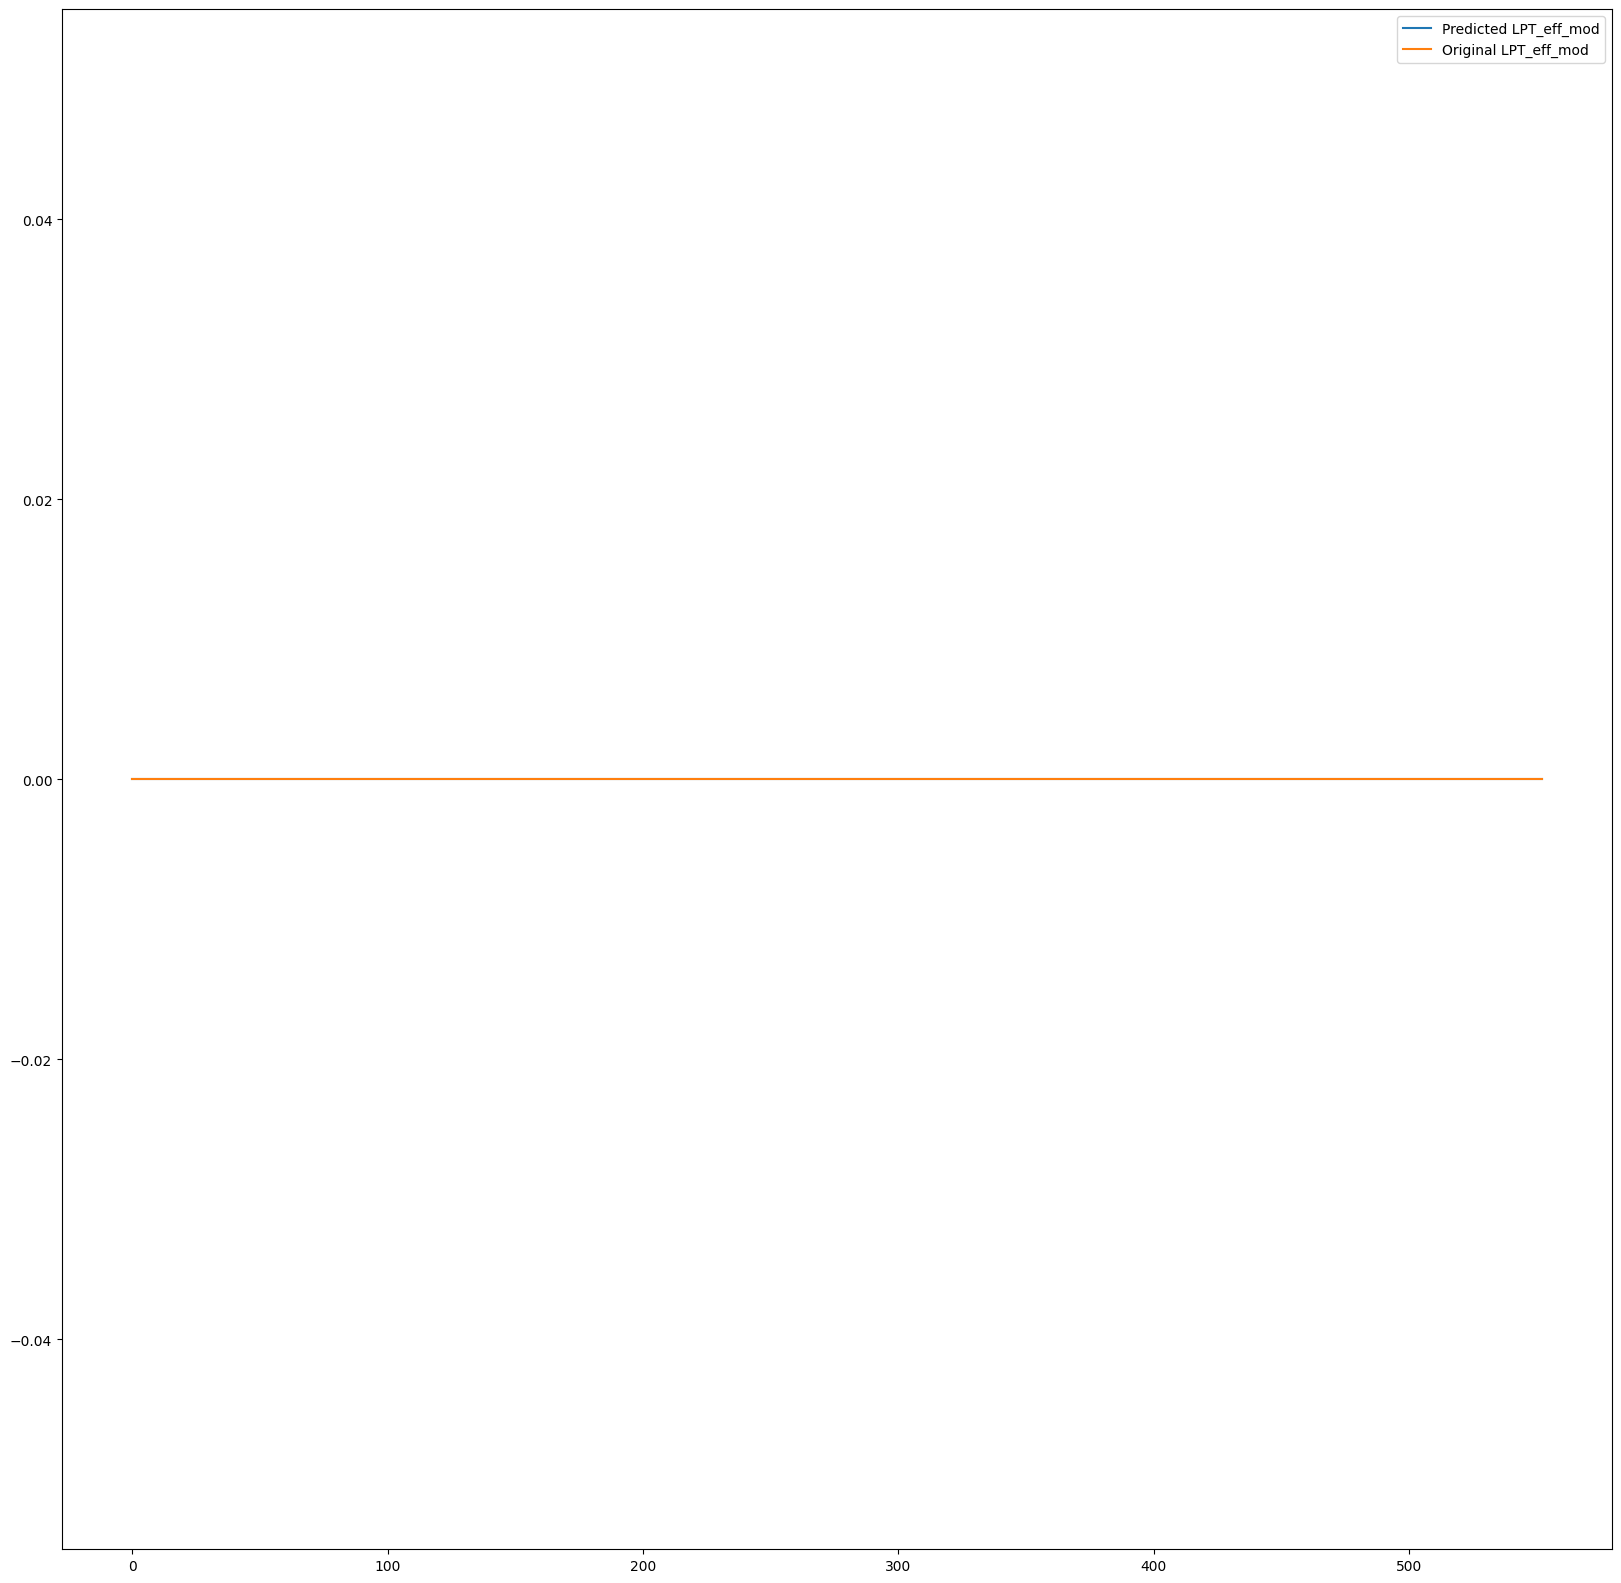

In [13]:
#plot the predicted T_map_mean data and compare it with the original data
# plot the predicted data
plt.figure(figsize=(20, 20))
plt.plot(y_pred[:,7], label='Predicted LPT_eff_mod')    
# plot the original data
plt.plot(y[:,7], label='Original LPT_eff_mod')
plt.legend(loc='best')
plt.show()

In [8]:
#predict the X_1 data and y_1 data using the MAP estimate
y_1_pred = gp(X_1, y_1, theta, noise)
# clip the predicted values to the maximum value of the training data
y_1_pred = np.clip(y_1_pred, None, np.max(y_1))

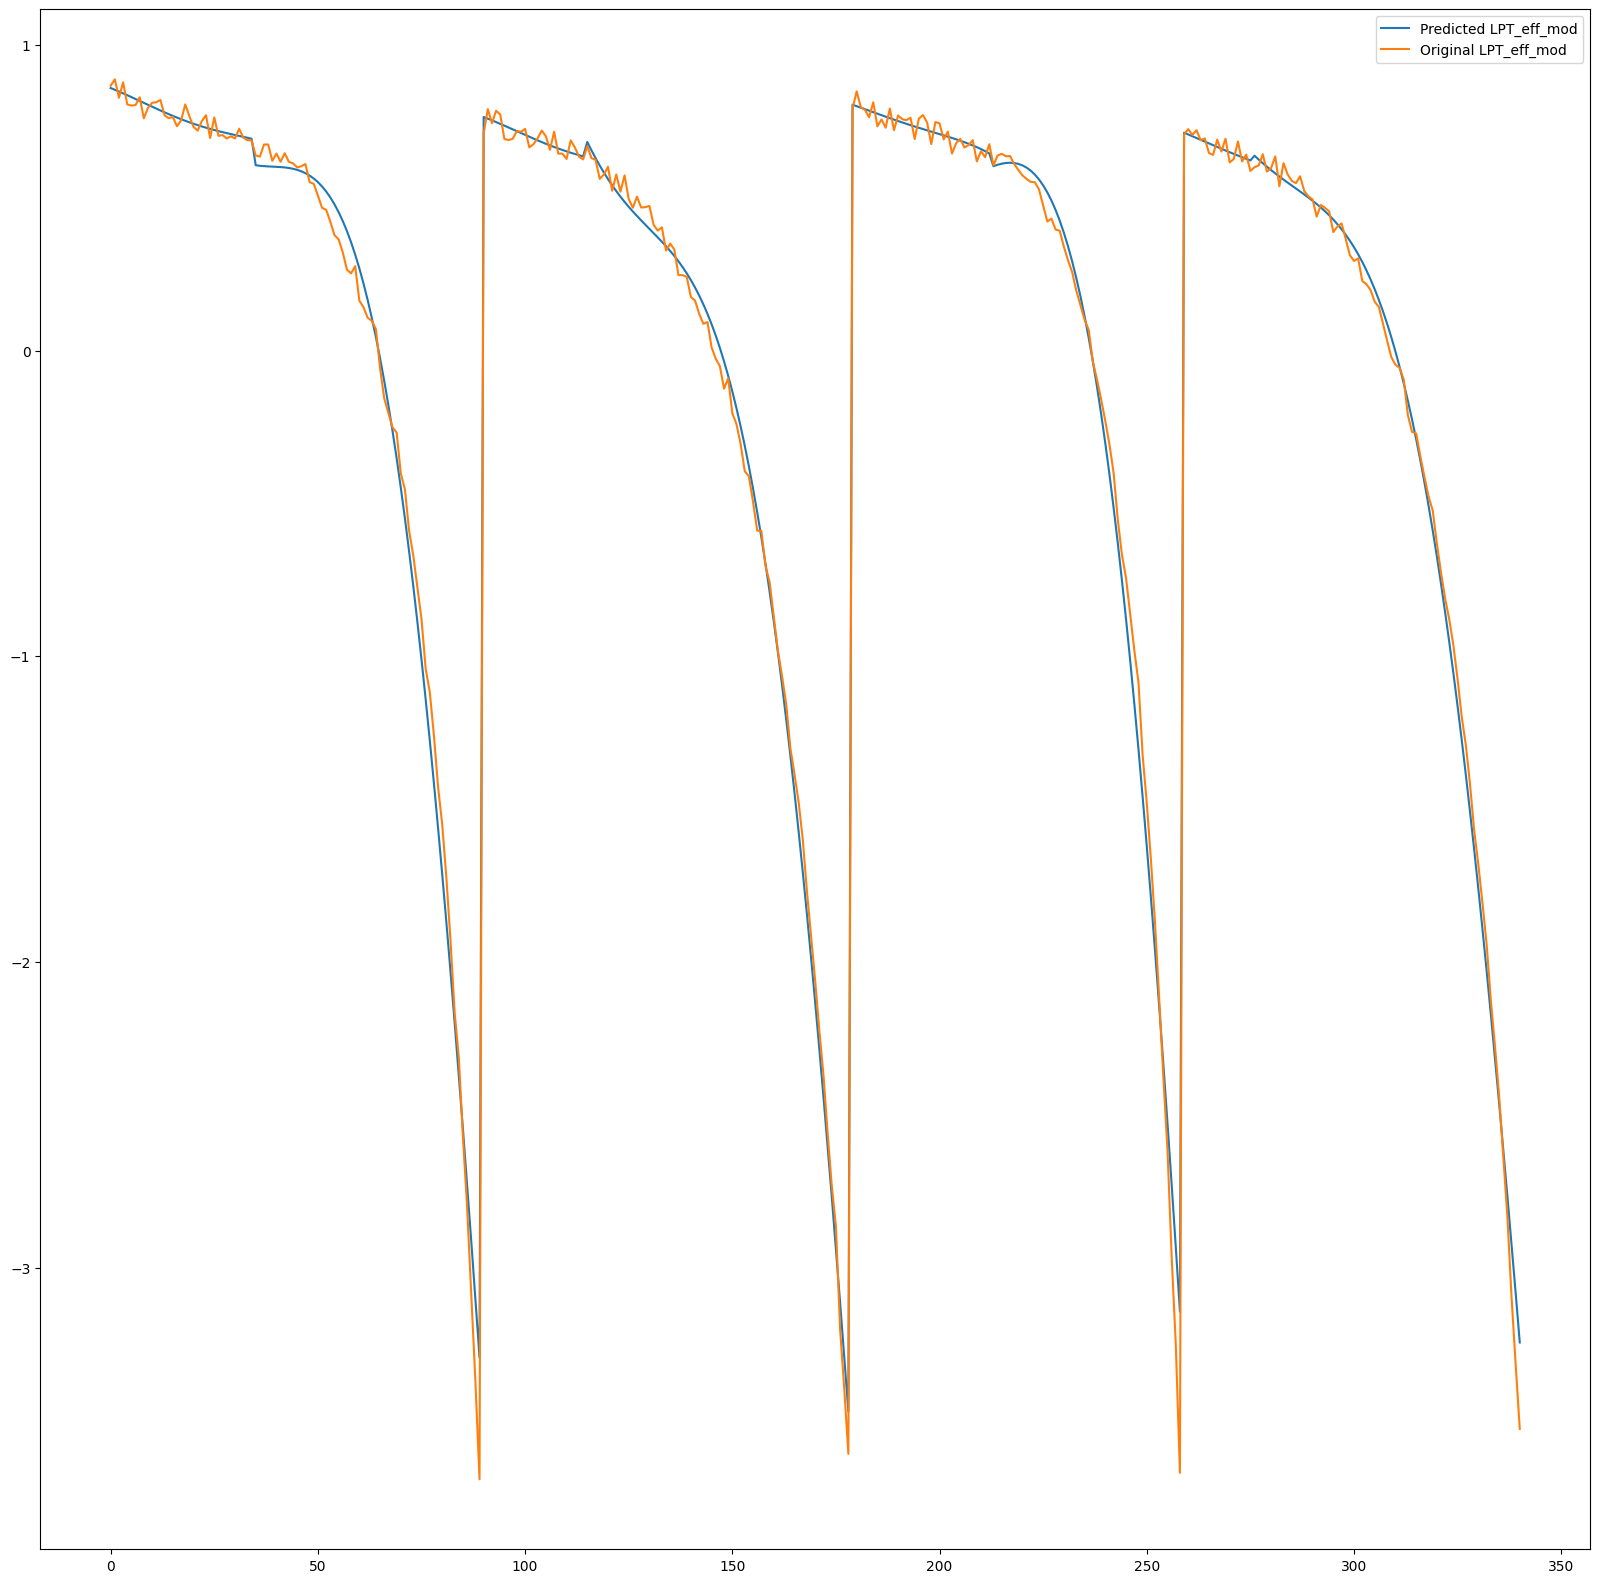

In [9]:
#plot the predicted T_map_mean data and compare it with the original data
# plot the predicted data
plt.figure(figsize=(20, 20))
plt.plot(y_1_pred[:,6], label='Predicted LPT_eff_mod')    
# plot the original data
plt.plot(y_1[:,6], label='Original LPT_eff_mod')
plt.legend(loc='best')
plt.show()


In [10]:
# inverse transform the predicted data
y_pred = scaler_y.inverse_transform(y_pred)
y_1_pred = scaler_y.inverse_transform(y_1_pred)


In [11]:
# Convert the predicted data to DataFrame to use as input for surrogate model
tetha_train = pd.DataFrame(data=y_pred, columns=['fan_eff_mod', 'fan_flow_mod', 'LPC_eff_mod', 'LPC_flow_mod', 'HPC_eff_mod', 'HPC_flow_mod', 'HPT_eff_mod', 'HPT_flow_mod', 'LPT_eff_mod', 'LPT_flow_mod'])
tetha_test = pd.DataFrame(data=y_1_pred, columns=['fan_eff_mod', 'fan_flow_mod', 'LPC_eff_mod', 'LPC_flow_mod', 'HPC_eff_mod', 'HPC_flow_mod', 'HPT_eff_mod', 'HPT_flow_mod', 'LPT_eff_mod', 'LPT_flow_mod'])

In [12]:
# Save DataFrames to CSV
tetha_train.to_csv('tetha_train_DS001.csv', index=False)
tetha_test.to_csv('tetha_test_DS001.csv', index=False)